In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import csv
from PIL import Image
from torchvision import transforms
import cv2
import numpy as np
import matplotlib.pyplot as plt

/home/jezjamez/work/assignment/Text Object Detection/ocrpytorch-master/venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
detection_model_path  = 'models/detection.pth'
recognition_model_path = 'models/recognition.pt'
test_images_path = "TestSet/"

In [3]:
mean = [0.5, 0.5, 0.5]
std = [0.25, 0.25, 0.25]
region_thresh = 0.09
affinity_thresh = 0.07
remove_thresh = 15 * 1e-3
long_side = 960

In [4]:
def make_layers():
    layers = []
    in_channels = 3
    m_cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']
    for i in m_cfg:
        if i == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, i, kernel_size=3, padding=1)
            layers += [conv2d, nn.BatchNorm2d(i), nn.ReLU(inplace=True)]
            in_channels = i
    return nn.Sequential(*layers)

In [5]:
def _init_parameters(net):
    for m in net:
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, 0, 0.01)
            nn.init.constant_(m.bias, 0)

In [6]:
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
        )
        _init_parameters(self.modules())
        
        def forward(self, x):
            out = []
            for m in self.features:
                x = m(x)
                if isinstance(m, nn.MaxPool2d):
                    out.append(x)
            x = self.conv_6(x)
            out.append(x)
            return out[1:]

In [7]:
class extractor(nn.Module):
    def __init__(self, pretrained):
        super(extractor, self).__init__()
        vgg16_bn = VGG(make_layers())
        if pretrained:
            vgg_pretrained_weight = 'models/vgg16.pth'
            vgg16_bn.load_state_dict(torch.load(vgg_pretrained_weight))
        self.features = vgg16_bn.features

        self.conv_6 = nn.Sequential(
                      nn.Conv2d(512, 512, 3, padding=1, bias=False),
                      nn.BatchNorm2d(512),
                      nn.ReLU(inplace=True),
                      nn.Conv2d(512, 512, 3, padding=1, bias=False),
                      nn.BatchNorm2d(512),
                      nn.ReLU(inplace=True))
        _init_parameters(self.conv_6.modules())

    def forward(self, x):
        out = []
        for m in self.features:
            x = m(x)
            if isinstance(m, nn.MaxPool2d):
                out.append(x)
        x = self.conv_6(x)
        out.append(x)
        return out[1:]

In [8]:
class upconv_block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(upconv_block, self).__init__()

        self.conv1 = nn.Conv2d(in_channel, out_channel*2, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channel*2)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channel*2, out_channel, 3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channel)
        self.relu2 = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu2(self.bn2(self.conv2(self.relu1(self.bn1(self.conv1(x))))))

In [9]:

class merge(nn.Module):
    def __init__(self):
        super(merge, self).__init__()

        self.upconv1 = upconv_block(1024, 256)
        self.upconv2 = upconv_block(512+256, 128)
        self.upconv3 = upconv_block(256+128, 64)
        self.upconv4 = upconv_block(128+64, 32)

        self.conv = nn.Sequential(
                    nn.Conv2d(32, 32, 3, padding=1, bias=False),
                    nn.BatchNorm2d(32),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(32, 32, 3, padding=1, bias=False),
                    nn.BatchNorm2d(32),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(32, 16, 3, padding=1, bias=False),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True),
                    nn.Conv2d(16, 16, 1, bias=False),
                    nn.BatchNorm2d(16),
                    nn.ReLU(inplace=True))

        self.region_head = nn.Conv2d(16, 1, 1)
        self.affinity_head = nn.Conv2d(16, 1, 1)
        self.sigmoid1 = nn.Sigmoid()
        self.sigmoid2 = nn.Sigmoid()
        _init_parameters(self.modules())

    def forward(self, x):
        y = torch.cat((x[4], x[3]), 1)
        y = self.upconv1(y)
        y = F.interpolate(y, scale_factor=2, mode='bilinear', align_corners=True)

        y = torch.cat((y, x[2]), 1)
        y = self.upconv2(y)
        y = F.interpolate(y, scale_factor=2, mode='bilinear', align_corners=True)

        y = torch.cat((y, x[1]), 1)
        y = self.upconv3(y)
        y = F.interpolate(y, scale_factor=2, mode='bilinear', align_corners=True)

        y = torch.cat((y, x[0]), 1)
        y = self.upconv4(y)
        y = F.interpolate(y, scale_factor=2, mode='bilinear', align_corners=True)

        y = self.conv(y)
        region_score = self.sigmoid1(self.region_head(y))
        affinity_score = self.sigmoid2(self.affinity_head(y))

        return region_score, affinity_score

In [10]:
class TextDetector(nn.Module):
    def __init__(self, pretrained=True):
        super(TextDetector, self).__init__()
        self.extractor = extractor(pretrained)
        self.merge  = merge()

    def forward(self, x):
        return self.merge(self.extractor(x))

In [11]:
def get_text(img, boxes):
    if boxes is None:
        return img
    count = 0
    text_list = []
    sorted_list = []
    open_cv_image = np.array(img)
    for box in boxes:
        count +=1
        box_x  = [box[x] for x in range(0,len(box),2)]
        box_y = [box[x] for x in range(1,len(box),2)]
        min_x = min(box_x) 
        max_x = max(box_x) 
        min_y = min(box_y) 
        max_y = max(box_y) 

        if len(sorted_list) == 0:
            sorted_list.append([[min_x, min_y, max_x, max_y]])
        else:
            matched = False
            for s_list in sorted_list:
                if abs(s_list[0][1] - min_y) < 15:
                    s_list.append([min_x, min_y, max_x, max_y])
                    matched = True
                    break
                    
            if matched == False:
                sorted_list.append([[min_x, min_y, max_x, max_y]])
    new_sorted_list = []
    for s_list in sorted_list:
        list_s = sorted(s_list, key=lambda s_list: s_list[0])
        new_sorted_list.append(list_s)
    
    for s_list in new_sorted_list:
        for s in s_list:
            open_cv_image_roi = open_cv_image[int(s[1]): int(s[3]) , int(s[0]): int(s[2])]
            text_list.append(open_cv_image_roi)

    return text_list

In [12]:
def resize_img(img, long_side):
    w, h = img.size
    if long_side is not None:
        if w > h:
            resize_w = long_side
            ratio = long_side / w
            resize_h = h * ratio
        else:
            resize_h = long_side
            ratio = long_side / h
            resize_w = w * ratio
    else:
        resize_h, resize_w = h, w

    final_h = int(resize_h) if resize_h % 32 == 0 else (int(resize_h / 32) + 1) * 32
    final_w = int(resize_w) if resize_w % 32 == 0 else (int(resize_w / 32) + 1) * 32
    img = img.resize((final_w, final_h), Image.BILINEAR)
    ratio_h = final_h / h
    ratio_w = final_w / w
    return img, ratio_h, ratio_w

In [13]:
def load_pil(img):
    t = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])
    return t(img).unsqueeze(0)

In [14]:
def get_score(img, model, device):
    with torch.no_grad():
        region, affinity = model(load_pil(img).to(device))
    return list(map(lambda x: x[0][0].cpu().numpy(), [region, affinity]))

In [15]:
def restore_boxes(region, affinity, region_thresh, affinity_thresh, remove_thresh, ratio):
    boxes = []
    # print(remove_thresh)
    M = (region > region_thresh) + (affinity > affinity_thresh)
    ret, markers = cv2.connectedComponents(np.uint8(M * 255))
    for i in range(ret):
        if i == 0:
            continue
        y,x=np.where(markers==i)
        if len(y) < region.size * remove_thresh:
            continue
        cords = 2 * np.concatenate((x.reshape(-1,1)/ratio[1], y.reshape(-1,1)/ratio[0]), axis=1)
        a = np.array([cords[:,0].min(), cords[:,1].min(), cords[:,0].max(), cords[:,1].min(), cords[:,0].max(), cords[:,1].max(), cords[:,0].min(), cords[:,1].max()])
        boxes.append(a)
    return boxes

In [16]:
def detect_single_image(img, model, device):
    img, ratio_h, ratio_w = resize_img(img, long_side)
    region, affinity = get_score(img, model, device)
    boxes = restore_boxes(region, affinity, region_thresh, affinity_thresh, remove_thresh, (ratio_h, ratio_w))
    return boxes

In [17]:
class FeatureExtractor:
    def __init__(self, input_channel=1, imgH=224, imgW=224):
        self.imgH = imgH
        self.imgW = imgW
        self.transform = NormalizePAD((input_channel, imgH, imgW))
    
    def __call__(self, img_path):
        img = Image.open(img_path).convert('L')
        img = img.resize((self.imgW, self.imgH), Image.BICUBIC)
        img = self.transform(img)
        img = torch.unsqueeze(img, dim=0)
        return img
    
class NormalizePAD:
    def __init__(self, max_size, PAD_type='right'):
        self.toTensor = transforms.ToTensor()
        self.max_size = max_size
        self.max_width_half = max_size[2] // 2 
        self.PAD_type = PAD_type

    def __call__(self, img):
        img = self.toTensor(img)
        img.sub_(0.5).div_(0.5)
        c, h, w = img.size()
        pad_img = torch.FloatTensor(*self.max_size).fill_(0)
        pad_img[:, :, :w] = img  # right pad
        if self.max_size[2] != w:  # add border Pad
            pad_img[:, :, w:] = img[:, :, w - 1].unsqueeze(2).expand(c, h, self.max_size[2] - w)

        return pad_img

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
detection_model = TextDetector().to(device)
detection_model.load_state_dict(torch.load(detection_model_path, map_location='cuda:0'))
detection_model.eval()

TextDetector(
  (extractor): extractor(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, 

In [19]:
class TokenLabelConverter:

    def __init__(self):
        character='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
        batch_max_length = 25
        self.SPACE = '[s]'
        self.GO = '[GO]'

        self.list_token = [self.GO, self.SPACE]
        self.character = self.list_token + list(character)

        self.dict = {word: i for i, word in enumerate(self.character)}
        self.batch_max_length = batch_max_length + len(self.list_token)

    def encode(self, text):

        length = [len(s) + len(self.list_token) for s in text]  # +2 for [GO] and [s] at end of sentence.
        batch_text = torch.LongTensor(len(text), self.batch_max_length).fill_(self.dict[self.GO])
        for i, t in enumerate(text):
            txt = [self.GO] + list(t) + [self.SPACE]
            txt = [self.dict[char] for char in txt]
            batch_text[i][:len(txt)] = torch.LongTensor(txt)  # batch_text[:, 0] = [GO] token
        return batch_text.to(device)

    def decode(self, text_index, length):
        texts = []
        for index, l in enumerate(length):
            text = ''.join([self.character[i] for i in text_index[index, :]])
            texts.append(text)
        return texts

In [20]:
def img2text(model, images, converter):
    pred_strs = []
    with torch.no_grad():
        for img in images:
            pred = model(img, seqlen=converter.batch_max_length)
            _, pred_index = pred.topk(1, dim=-1, largest=True, sorted=True)
            pred_index = pred_index.view(-1, converter.batch_max_length)
            length_for_pred = torch.IntTensor([converter.batch_max_length - 1] )
            pred_str = converter.decode(pred_index[:, 1:], length_for_pred)
            pred_EOS = pred_str[0].find('[s]')
            pred_str = pred_str[0][:pred_EOS]

            pred_strs.append(pred_str)

    return pred_strs

In [21]:
!/home/jezjamez/work/Assignment1/models/


/bin/bash: line 1: /home/jezjamez/work/Assignment1/models/: Is a directory


In [22]:
recognition_model = torch.load(recognition_model_path)
recognition_model.to(device)
recognition_model.eval()

/home/jezjamez/work/assignment/Text Object Detection/ocrpytorch-master/venv/lib/python3.10/site-packages/torch/serialization.py:758: UserWarning: 'torch.load' received a zip file that looks like a TorchScript archive dispatching to 'torch.jit.load' (call 'torch.jit.load' directly to silence this warning)
  warnings.warn("'torch.load' received a zip file that looks like a TorchScript archive"


RecursiveScriptModule(
  original_name=JitModel
  (vitstr): RecursiveScriptModule(
    original_name=ViTSTR
    (patch_embed): RecursiveScriptModule(
      original_name=PatchEmbed
      (proj): RecursiveScriptModule(original_name=Conv2d)
      (norm): RecursiveScriptModule(original_name=Identity)
    )
    (pos_drop): RecursiveScriptModule(original_name=Dropout)
    (blocks): RecursiveScriptModule(
      original_name=Sequential
      (0): RecursiveScriptModule(
        original_name=Block
        (norm1): RecursiveScriptModule(original_name=LayerNorm)
        (attn): RecursiveScriptModule(
          original_name=Attention
          (qkv): RecursiveScriptModule(original_name=Linear)
          (attn_drop): RecursiveScriptModule(original_name=Dropout)
          (proj): RecursiveScriptModule(original_name=Linear)
          (proj_drop): RecursiveScriptModule(original_name=Dropout)
        )
        (drop_path): RecursiveScriptModule(original_name=Identity)
        (norm2): RecursiveScrip

In [23]:
converter = TokenLabelConverter()

/tmp/ipykernel_9357/3785152679.py:17: DeprecationWarning: BILINEAR is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BILINEAR instead.
  img = img.resize((final_w, final_h), Image.BILINEAR)
/tmp/ipykernel_9357/3715553976.py:9: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  img = img.resize((self.imgW, self.imgH), Image.BICUBIC)


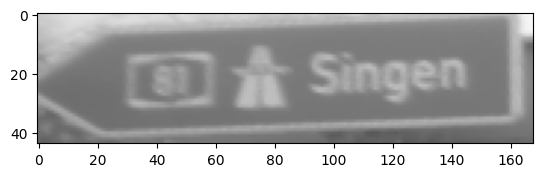

 of Singen


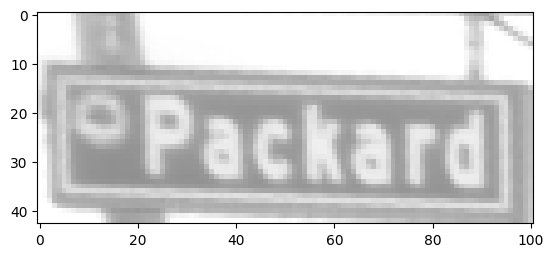

 ropackard


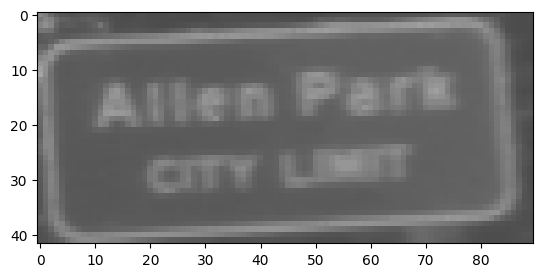

 I Allen oh Park ony


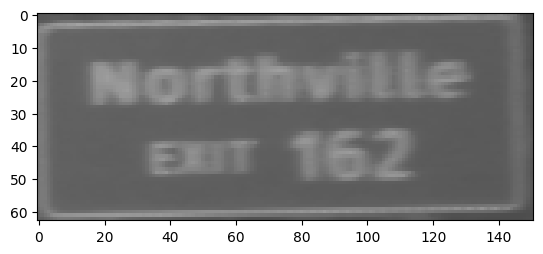

 Northville Exi 162


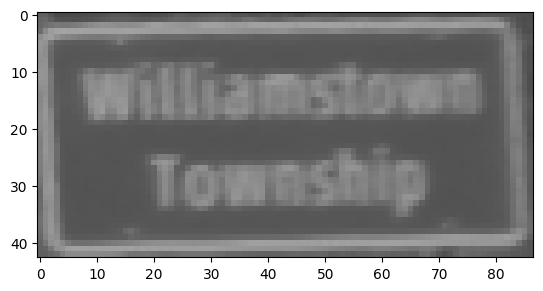

 milanm Township


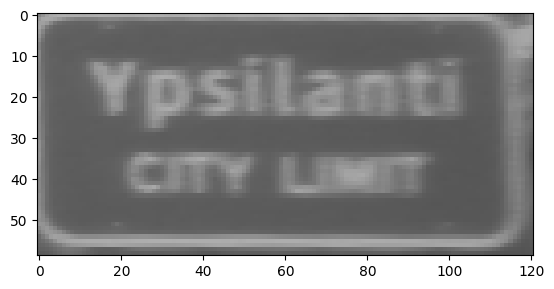

 Ypsilanti an oue


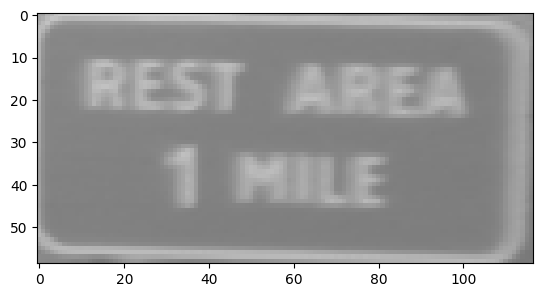

 REST AREA 1 MILE


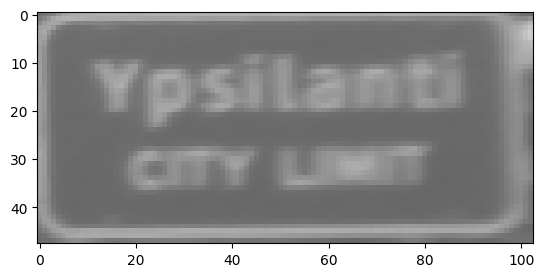

 Ypsilanti any cun


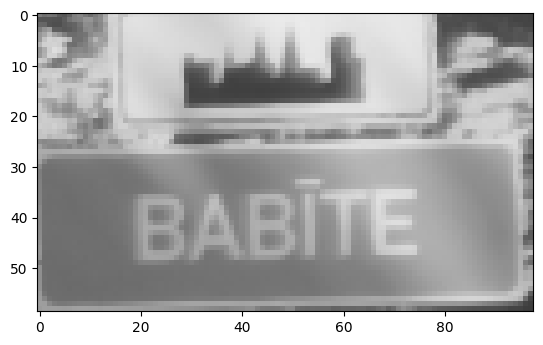

 BABITE


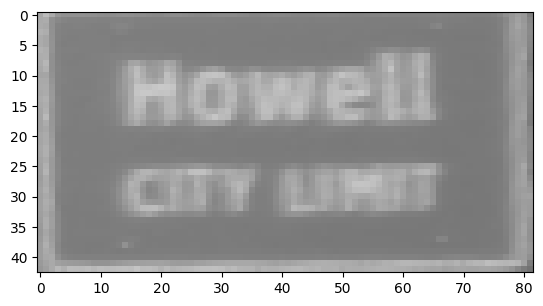

 Howell Cnty in


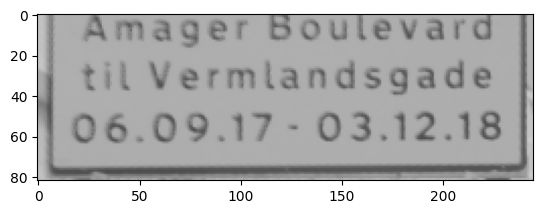

 Amager Boulevard til Vermlandsgade 0619917 031218


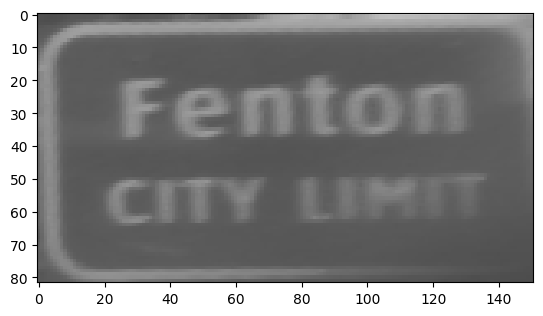

 I Fenton CITY limIt


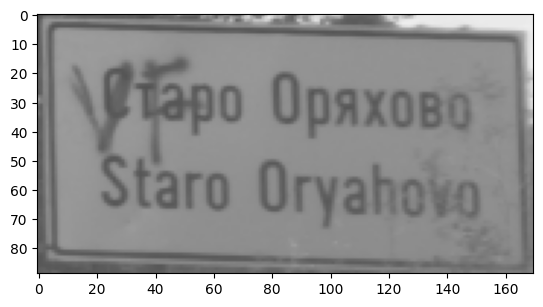

 Crapo Opaxobo Staro Oryahovo


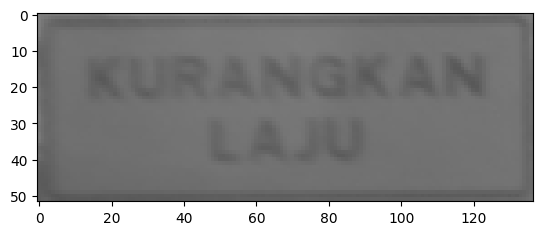

 KURANGKAN LAJU


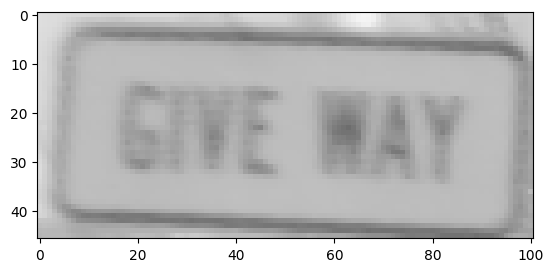

 IGive way


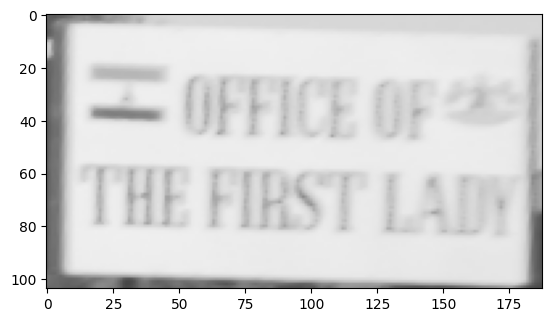

 It OFFicE Its the fIrst LADY


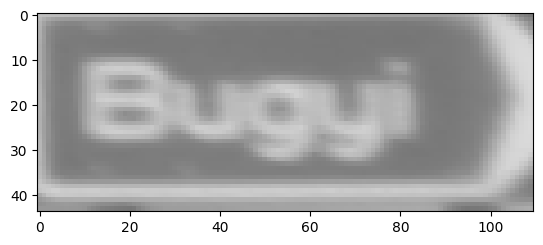

 Bugy


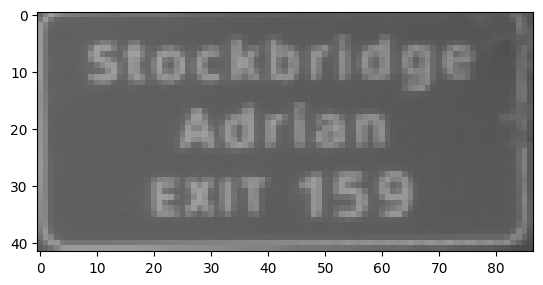

 Stockbridge Adrian exit 159


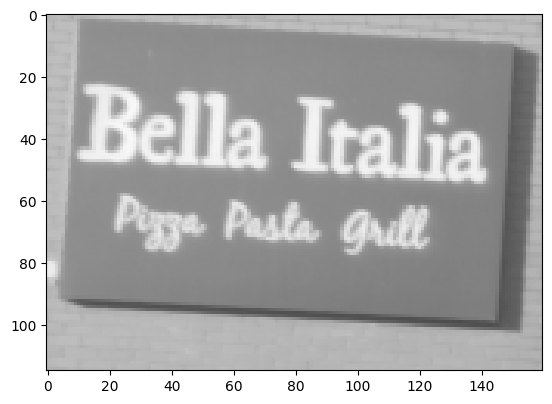

 Bella Italia Pizza Pasta Grill


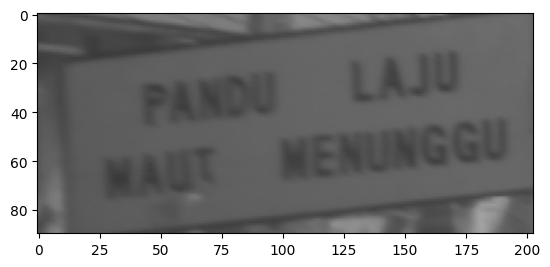

 PANDU LAJU waut MENUNGGU and


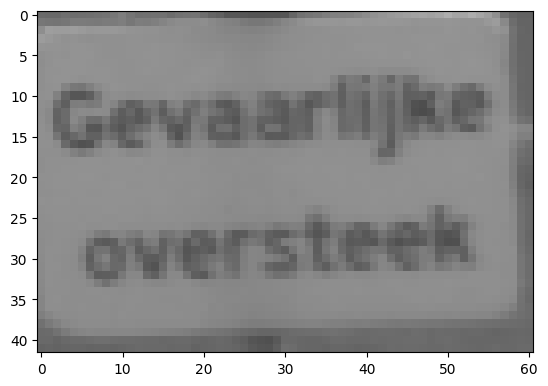

 Gevaarljjie oversteek


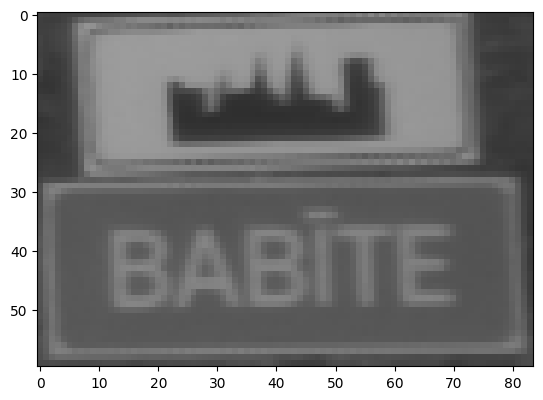

 will BABITE


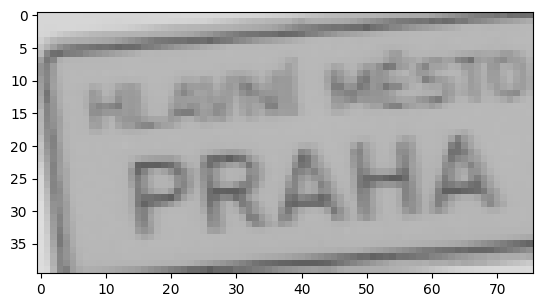

 HLAWnI PRAHA MEStO


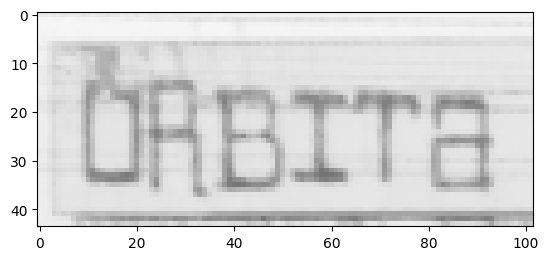

 DRBITa


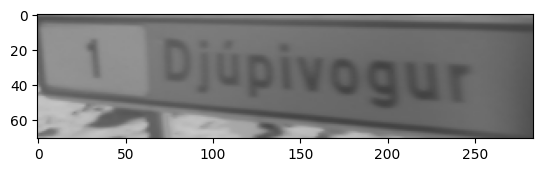

 Djupivogur


In [28]:
test_images = os.listdir(test_images_path)
extractor = FeatureExtractor()
plt.figure()

f = open('results.csv', 'w')
writer = csv.writer(f)
writer.writerow(['file_name','text'])
for img_n in test_images:
    img_path = os.path.join(test_images_path, img_n)
    img = Image.open(img_path)
    boxes = detect_single_image(img, detection_model, device)
    text_img_list = get_text(img, boxes)
    count = 0
    strr = ''
    for text_img in text_img_list:
        count +=1
        cv2.imwrite("detection_out/"+img_n+str(count) +'.png', text_img)
        image = extractor("detection_out/"+img_n+str(count) +'.png')
        image = image.to(device)
        images = [image]
        pred_strs = img2text(recognition_model, images, converter)
        strr += ' ' + pred_strs[0]
    
    plt.imshow(img) 
    plt.show() 
    print(strr)
    
    fields = [img_n, strr ]
    writer.writerow(fields)

f.close()
        